Notebook for training and testing a dense neural network model using an adjacency matrix represention of the buffer overflow datapoints in an AST format. 

First, the data is padded with zeros in a standardized format - from the right and down.

Next, we incorporate random padding on the matrices in the testing dataset. 

Then, we randomly pad both the training and testing dataset.

Finally, we train the model on randomly padded data and test on standardized padded data. 

# Colab Setup

In [1]:
!mkdir -p /project/data && cd /project/data && wget -O adj.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adj.pickle
!mkdir -p /project/data && cd /project/data && wget -O buffer_overflow_data.csv.gz https://github.com/dj311/uob-summer-project/raw/master/data/buffer_overflow_data.csv.gz
!mkdir -p /project/data && cd /project/data && wget -O adjacency-matrix-model-binary.pickle https://github.com/dj311/uob-summer-project/raw/master/data/adjacency-matrix-model-binary.pickle
!mkdir -p /project/data && cd /project/data && wget -O feature_matrix.pickle https://github.com/dj311/uob-summer-project/raw/master/data/feature_matrix.pickle
!mkdir -p /project/code
%cd /project/code

--2019-08-29 12:04:39--  https://github.com/dj311/uob-summer-project/raw/master/data/adj.pickle
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/dj311/uob-summer-project/master/data/adj.pickle [following]
--2019-08-29 12:04:40--  https://media.githubusercontent.com/media/dj311/uob-summer-project/master/data/adj.pickle
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1320521199 (1.2G) [application/octet-stream]
Saving to: ‘adj.pickle’

adj.pickle          100%[===================>]   1.23G   250MB/s    in 5.3s    

2019-08-29 12:04:56 (239 MB/s) - ‘adj.pickle’ saved [1320521199/132052119

# Import & Preprocess Dataset

First we import the data from the [previous notebook](./adjacency_matrix.ipynb).


In [3]:
import tensorflow as tf
import keras
import sklearn
import numpy as np
import pickle
from scipy.sparse import csr_matrix, hstack, vstack
from sklearn.model_selection import train_test_split

run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)
np.random.seed(1248)

tf.logging.set_verbosity(tf.logging.INFO)

Using TensorFlow backend.


In [0]:
import pandas as pd

In [0]:
data = pd.read_csv('../data/buffer_overflow_data.csv.gz')

In [0]:
labels = data.copy()
del labels['Unnamed: 0']
del labels['Unnamed: 0.1']
del labels['filename']
del labels['code']
del labels['flaw']
del labels['flaw_loc']
labels = labels.drop_duplicates().sort_values('testcase_ID').reset_index(drop=True)

In [0]:
with open("../data/adj.pickle",'rb') as f:
    adj = pickle.load(f)

In [0]:
adj = adj.rename(columns={0: 'testcase_ID', 1: 'adjacency_matrix'})

In [0]:
adj_orig_df = pd.merge(labels, adj, on='testcase_ID')

In [0]:
adj_orig_df = adj_orig_df[['testcase_ID', 'adjacency_matrix', 'bug']]

Next, find out the maximum size of an adjacency matrix, then convert all matrices to have the same dimension.

In [0]:
adj_orig_df['matrix_size'] = adj_orig_df.adjacency_matrix.apply(lambda x: x.shape[0])

In [12]:
adj_orig_df['matrix_size'].describe()

count    21502.000000
mean      2186.138778
std       7239.752920
min          4.000000
25%        349.000000
50%        396.000000
75%        614.000000
max      44401.000000
Name: matrix_size, dtype: float64

So we know that 75% of the dataset has a matrix size <= 614, which is approximately 18000 datapoints. Picking the full dataset would require matrices of dimension 44401x44401 which require 15 gb of memory each. This is isn't feasible, however picking matrices of size 614x614 or less gives a per matrix size of 3.38mb - far more manageable!

In [13]:
matrix_size = 614
adj_orig_df = adj_orig_df[adj_orig_df['matrix_size'] <= matrix_size]
len(adj_orig_df)

16128

In [0]:
adj_df = adj_orig_df.copy()

In [0]:
def bottom_right_matrix_size_corrector(matrix, target_rows, target_columns):
    '''Pads matrix with zeros to the desired size'''
    
    rows, columns = matrix.shape[0], matrix.shape[1]
    
    row_corrector = csr_matrix((target_rows-rows, columns))
    col_corrector = csr_matrix((target_rows, target_columns-columns))

    matrix = vstack([matrix, row_corrector])
    matrix = hstack([matrix, col_corrector])

    matrix = matrix.astype(np.int)
    
    return matrix 

In [0]:
adj_df['adjacency_matrix'] = adj_df['adjacency_matrix'].apply(lambda m: bottom_right_matrix_size_corrector(m, matrix_size, matrix_size))

Next we load in the feature matrices:

In [0]:
with open("../data/feature_matrix.pickle", "rb") as f:
    feature_matrix = pickle.load(f)

feature_matrix.columns = ['testcase_ID', 'feature_matrix']

In [0]:
num_features = 55

In [0]:
adj_feat_df = pd.merge(feature_matrix, adj_df, on='testcase_ID')

In [0]:
adj_feat_df['feature_matrix'] = adj_feat_df['feature_matrix'].apply(lambda m: bottom_right_matrix_size_corrector(m, matrix_size, num_features))


In [0]:
testcase_ids = adj_feat_df['testcase_ID'].values
adjacency_matrices = adj_feat_df['adjacency_matrix'].values
feature_matrices = adj_feat_df['feature_matrix'].values
labels = adj_feat_df['bug'].values

Now we have a dataframe for each testcase with a sparse representation of its AST in the matrix column, each normalised to matrix_size x matrix_size in size.
  



Finally, we generate the train and test splits:

In [0]:
adj_train, adj_test, feat_train, feat_test, labels_train, labels_test = train_test_split(adjacency_matrices, feature_matrices, labels, test_size=0.2, random_state=0)

Storing all of these matrices in a dense representation at once might cause memory issues. To avoid this, we write a class which generates dense matrices for each of the training batches. 

We also perform the element wrapping as part of this process (since we can't perform it on the sparse arrays, I think).

In [0]:
class SparseToDenseGenerator(keras.utils.Sequence):

    def __init__(self, sparse_adjs, sparse_feats, labels, batch_size):
        self.sparse_adjs = sparse_adjs
        self.sparse_feats = sparse_feats
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.labels) / float(self.batch_size)))

    def __getitem__(self, batch_num):
        start_index = batch_num * self.batch_size
        end_index = (batch_num + 1) * self.batch_size
        
        batch_sparse_adjs = self.sparse_adjs[start_index:end_index]
        batch_sparse_feats = self.sparse_feats[start_index:end_index]
        batch_labels = self.labels[start_index:end_index]
        
        batch_dense_adjs = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse_adjs])
        batch_dense_feats = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse_feats])
        
        # TODO: move this somewhere better
        # Conv2D requires an extra dimension for "channels", so we need to convert our data from
        # the shape (batch_size, matrix_rows, matrix_columns)
        # to (batch_size, matrix_rows, matrix_columns, 1)
        batch_dense_adjs = np.reshape(batch_dense_adjs, batch_dense_adjs.shape + (1, ))
        batch_dense_feats = np.reshape(batch_dense_feats, batch_dense_feats.shape + (1, ))

        return [batch_dense_feats], np.array(batch_labels)

# Model

In [0]:
from keras.layers import Dense, Dropout, Flatten, Reshape, Activation
from keras.layers import Conv1D, MaxPooling1D, Conv2D, GlobalMaxPooling2D, MaxPooling2D, Convolution2D
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adadelta, Adam
from keras.utils import np_utils
from keras import backend as K

In [25]:
batch_size = 96
epochs = 5
num_samples = len(labels)
num_features = feature_matrices[0].shape[1]

datapoint_shape = (matrix_size, matrix_size, )
batch_shape = (batch_size, ) + datapoint_shape

steps_per_epoch = int(np.ceil(num_samples/batch_size))

kernel_size = (2, 2)
strides = max(kernel_size[0] // 3, 1)

batch_size, epochs, num_samples, datapoint_shape, batch_shape, steps_per_epoch, kernel_size, strides

(96, 5, 16128, (614, 614), (96, 614, 614), 168, (2, 2), 1)

In [0]:
num_features = 614

In [0]:
feat_train = adj_train

feat_test = adj_test

In [51]:
features_input = keras.layers.Input(shape=(matrix_size, num_features, 1))

f_flatten = Flatten(data_format='channels_last')(features_input)

f_dense1 = Dense(units=20, activation='relu')(f_flatten)
f_dense2 = Dense(units=20, activation='relu')(f_dense1)
f_dense3 = Dense(units=20, activation='relu')(f_dense2)
f_dense4 = Dense(units=20, activation='relu')(f_dense3)
f_dense5 = Dense(units=20, activation='relu')(f_dense4)

dense_input = keras.models.Model(inputs = features_input, outputs= f_dense5)

# Combine outputs of both networks via a set of dense, linear layers
# concat = keras.layers.concatenate(inputs=[conv_model.output ,dense_input.output])
c_dense1 =  Dense(units=20, activation='relu')(f_dense5)
c_dense2 =  Dense(units=20, activation='relu')(c_dense1)
c_dense3 =  Dense(units=20, activation='relu')(c_dense2)
c_dense3 =  Dense(units=20, activation='relu')(c_dense2)
c_dense3 =  Dense(units=20, activation='relu')(c_dense2)
c_dense3 =  Dense(units=20, activation='relu')(c_dense2)
c_dense3 =  Dense(units=20, activation='relu')(c_dense2)
c_dense3 =  Dense(units=20, activation='relu')(c_dense2)

# Dropout and final output layer
c_output = Dense(units=1, activation='sigmoid')(c_dense3)

model = keras.models.Model(inputs=dense_input.input, outputs=c_output)

model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 614, 614, 1)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 376996)            0         
_________________________________________________________________
dense_15 (Dense)             (None, 20)                7539940   
_________________________________________________________________
dense_16 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_17 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_18 (Dense)             (None, 20)                420       
_________________________________________________________________
dense_19 (Dense)             (None, 20)                420       
__________

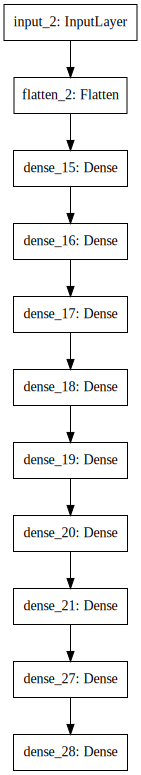

In [52]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

keras.utils.vis_utils.pydot = pyd

def visualize_model(model):
  return model_to_dot(model).create(prog='dot', format='svg')

model_diagram = visualize_model(model)

with open('../images/adj-feat-architecture-dnn.svg', 'wb') as f:
    f.write(model_diagram)

SVG(model_diagram)

It takes about 10 mins

In [53]:
training_batch_generator = SparseToDenseGenerator(adj_train, feat_train, labels_train, batch_size)
val_batch_generator = SparseToDenseGenerator(adj_test, feat_test, labels_test, batch_size)

history = model.fit_generator(
    generator=training_batch_generator,
    validation_data=val_batch_generator, 
    epochs=epochs,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/5
168/168 [==============================] - 88s 523ms/step - loss: 0.5368 - acc: 0.7036 - val_loss: 0.3729 - val_acc: 0.8326
Epoch 2/5
168/168 [==============================] - 84s 503ms/step - loss: 0.2836 - acc: 0.8728 - val_loss: 0.1989 - val_acc: 0.9222
Epoch 3/5
168/168 [==============================] - 88s 523ms/step - loss: 0.1298 - acc: 0.9520 - val_loss: 0.1372 - val_acc: 0.9538
Epoch 4/5
168/168 [==============================] - 83s 496ms/step - loss: 0.0670 - acc: 0.9768 - val_loss: 0.1154 - val_acc: 0.9647
Epoch 5/5
168/168 [==============================] - 91s 540ms/step - loss: 0.0564 - acc: 0.9795 - val_loss: 0.1465 - val_acc: 0.9516


In [0]:
with open('../data/adjacency-dense-model-binary.pickle', 'wb') as f:
    pickle.dump(model,f)

In [0]:
with open('../data/adjacency-dense-model-binary-history.pickle', 'wb') as f:
    pickle.dump(history,f)

# Evaluation

In [0]:
model = None
with open('../data/adjacency-dense-model-binary.pickle', 'rb') as f:
    model = pickle.load(f)

In [35]:
test_batch_generator = SparseToDenseGenerator(adj_test, feat_test, labels_test, batch_size)

model.evaluate_generator(
    generator=test_batch_generator,
)

[0.10700968710875389, 0.9686918790785334]

# Visualisations

In [0]:
import seaborn as sns
from sklearn import metrics
import matplotlib

In [0]:
class SparseToDensePredictGenerator(keras.utils.Sequence):

    def __init__(self, sparse_adjs, sparse_feats, batch_size):
        self.sparse_adjs = sparse_adjs
        self.sparse_feats = sparse_feats
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.sparse_feats) / float(self.batch_size)))

    def __getitem__(self, batch_num):
        start_index = batch_num * self.batch_size
        end_index = (batch_num + 1) * self.batch_size
        
        batch_sparse_adjs = self.sparse_adjs[start_index:end_index]
        batch_sparse_feats = self.sparse_feats[start_index:end_index]
        
        batch_dense_adjs = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse_adjs])
        batch_dense_feats = np.array([sparse_matrix.todense() for sparse_matrix in batch_sparse_feats])
        
        # TODO: move this somewhere better
        # Conv2D requires an extra dimension for "channels", so we need to convert our data from
        # the shape (batch_size, matrix_rows, matrix_columns)
        # to (batch_size, matrix_rows, matrix_columns, 1)
        batch_dense_adjs = np.reshape(batch_dense_adjs, batch_dense_adjs.shape + (1, ))
        batch_dense_feats = np.reshape(batch_dense_feats, batch_dense_feats.shape + (1, ))

        return [batch_dense_feats]

In [0]:
predict_batch_generator = SparseToDensePredictGenerator(adj_test, feat_test, batch_size)
y_predict = model.predict_generator(predict_batch_generator)

In [0]:
import numpy as np

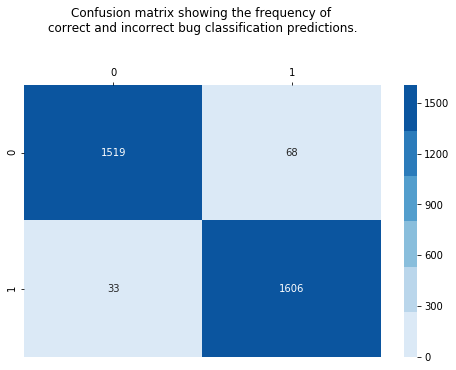

In [44]:
confusion_matrix = pd.DataFrame(
    data=metrics.confusion_matrix(labels_test, np.rint(y_predict)),
)

confusion_figure, confusion_axes = matplotlib.pyplot.subplots()
confusion_figure.set_size_inches(8, 5)
confusion_axes.set_title(
    'Confusion matrix showing the frequency of \n'
    'correct and incorrect bug classification predictions.'
    '\n\n'  # hack to avoid overlap with x-axis labels below
)
confusion_axes.xaxis.tick_top()  # move x-axis labels to top of matrix
_ = sns.heatmap(
    confusion_matrix,
    annot=True,
    fmt="d",
    cmap=sns.color_palette("Blues"),
    vmin=0,
    ax=confusion_axes,
)

In [45]:
np.argmax(labels_test.astype(int)), np.argmax(np.rint(y_predict)),

(4, 4)

In [0]:
# from sklearn.metrics import roc_curve
# fpr_keras, tpr_keras, thresholds_keras = roc_curve(
#     labels_test.astype(int),
#     np.rint(y_predict),
# )
y_test = labels_test
from sklearn.metrics import auc, roc_curve, precision_recall_curve, matthews_corrcoef, f1_score, roc_auc_score
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, np.rint(y_predict))
precision, recall, thresholds = precision_recall_curve(y_test, np.rint(y_predict))

In [0]:
import matplotlib.pyplot as plt

auc_keras = auc(fpr_keras, tpr_keras)
roc_auc = roc_auc_score(y_test, np.rint(y_predict))
pr_auc = auc(recall, precision)
f1 = f1_score(y_test, np.rint(y_predict))
mcc = matthews_corrcoef(y_test, np.rint(y_predict))

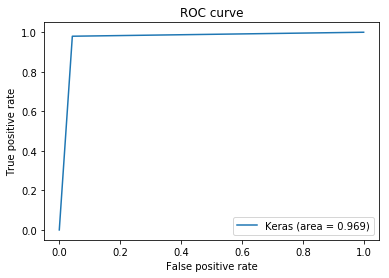

In [48]:
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [0]:
tn, fp, fn, tp = metrics.confusion_matrix(
    labels_test.astype(int), 
    np.rint(y_predict)
).flatten().tolist()

fpr_nn = fp/(fp+tp)
fnr_nn = fn/(fn+tn)

In [50]:
fpr_nn, fnr_nn

(0.04062126642771804, 0.021262886597938145)

In [0]:
from sklearn.metrics import roc_curve, precision_recall_curve, matthews_corrcoef, f1_score, roc_auc_score, auc, confusion_matrix, precision_score, recall_score
import numpy as np
import pandas as pd

def rates(y_test, y_predict):
    tn, fp, fn, tp = confusion_matrix(
    y_test.astype(int), 
    np.rint(y_predict)
    ).flatten().tolist()

    fpr = fp/(fp+tp)
    fnr = fn/(fn+tn)
    return fpr, fnr

def get_metrics(y_test, y_predict):
    fpr_plot, tpr_plot, thresholds_roc = roc_curve(y_test, y_predict)
    precision_plot, recall_plot, thresholds_pr = precision_recall_curve(y_test, y_predict)
    roc_auc = roc_auc_score(y_test, y_predict)
    pr_auc = auc(recall_plot, precision_plot)
    f1 = f1_score(y_test, np.rint(y_predict))
    mcc = matthews_corrcoef(y_test, np.rint(y_predict))
    precision = precision_score(y_test, np.rint(y_predict))
    recall = recall_score(y_test, np.rint(y_predict))
    fpr, fnr = rates(y_test, y_predict)
    metric_values = {
        'fpr_plot' : fpr_plot,
        'tpr_plot' : tpr_plot,
        'precision_plot' : precision_plot,
        'recall_plot' : recall_plot,
        'thresholds_pr' : thresholds_pr,
        'ROC AUC' : roc_auc,
        'Precision Recall AUC' : pr_auc,
        'F1 Score' : f1,
        'Matthews Correlation Coefficient' : mcc,
        'Precision' : precision,
        'Recall' : recall,
        'FPR' : fpr,
        'FNR' : fnr
    }
    return metric_values

In [0]:
metrics_adj_dense = get_metrics(y_test, y_predict)

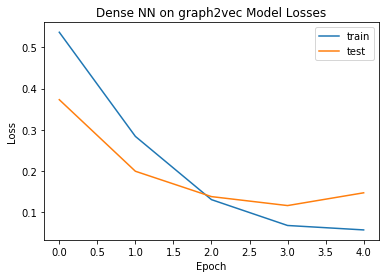

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Dense NN on graph2vec Model Losses')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')

In [0]:
model_names = pd.DataFrame({
  'Model': [
    'Dense NN on adj'
  ]
})

model_accuracies = pd.DataFrame({
  'Accuracy' : [
      0.969            
  ]
})

all_metrics = pd.DataFrame(
    [metrics_adj_dense] #add in cnn adj and cnn adj/feat random padded
)
all_metrics = model_names.join(model_accuracies).join(all_metrics)

key_metrics = all_metrics.filter(['Model', 'Accuracy', 'Precision', 'Recall', 'FPR', 'FNR'])

deep_learning_metrics = all_metrics.filter(['Model', 'ROC AUC', 'Precision Recall AUC', 'F1 Score', 'Matthews Correlation Coefficient'])

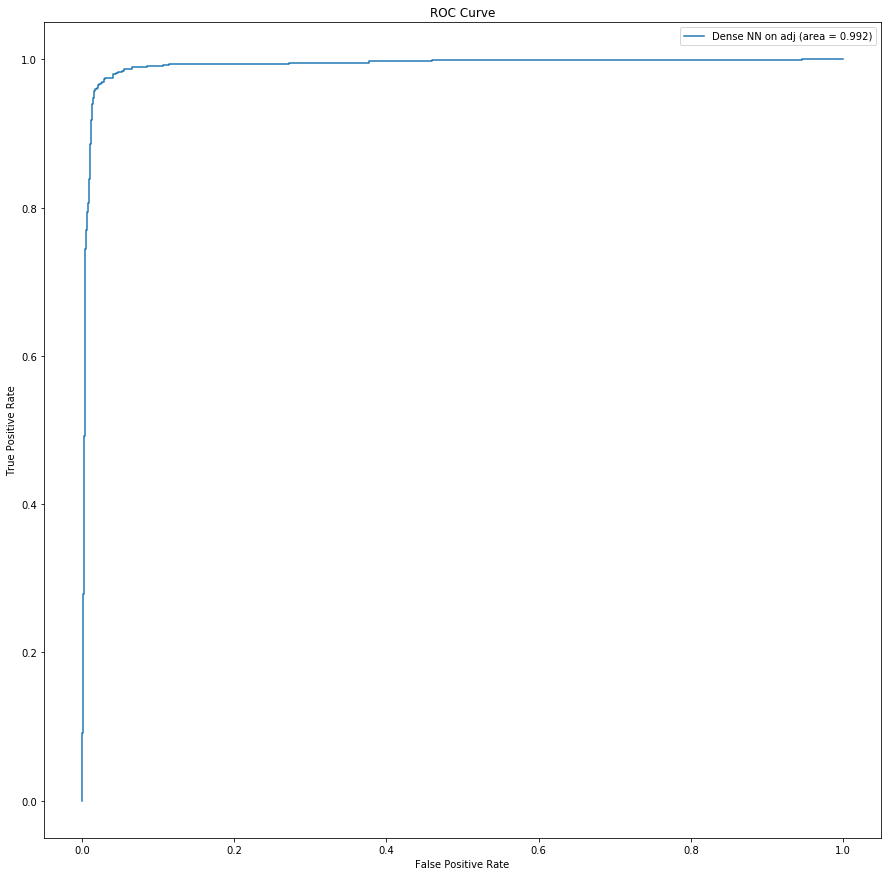

In [60]:
plt.figure(figsize=(15,15))
for index, row in all_metrics.iterrows():
  if row['Model'] == 'Stacked Model':
    plt.plot(row['fpr_plot'][1], row['tpr_plot'][1], 'x', markersize = 20, label='{} (area = {:.3f})'.format(row['Model'], row['ROC AUC']))
  else:
    plt.plot(row['fpr_plot'], row['tpr_plot'], label='{} (area = {:.3f})'.format(row['Model'], row['ROC AUC']))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')


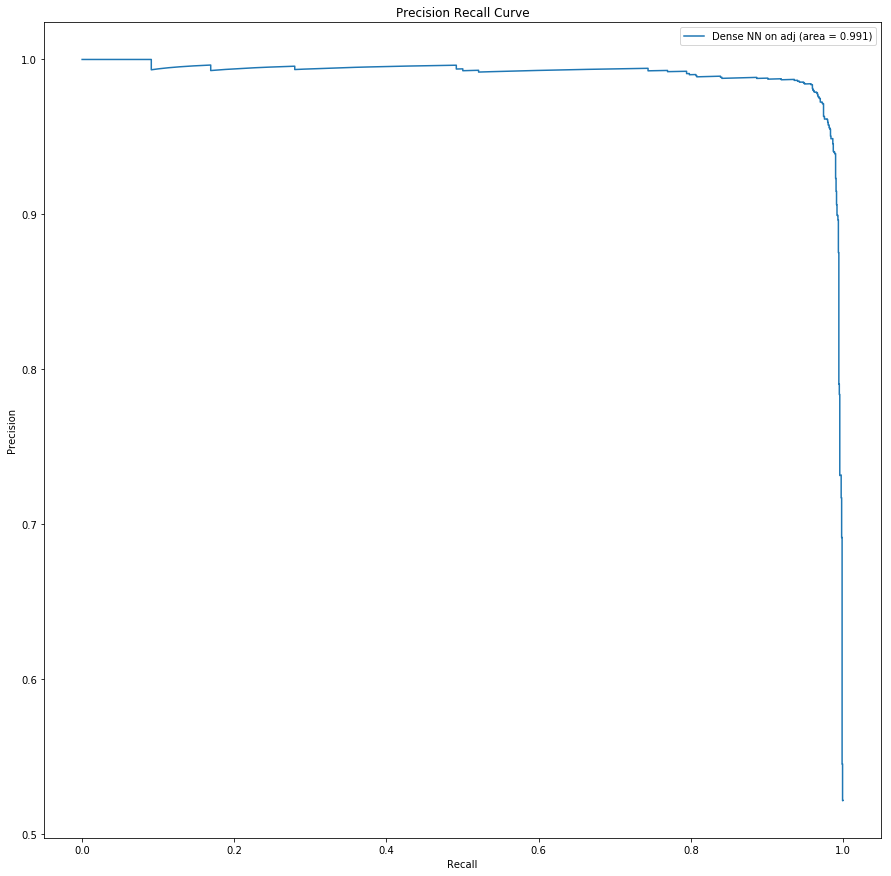

In [61]:
plt.figure(figsize=(15,15))
for index, row in all_metrics.iterrows():
  if row['Model'] == 'Stacked Model':
    plt.plot(row['recall_plot'][1], row['precision_plot'][1], 'x', markersize = 20, label='{} (area = {:.3f})'.format(row['Model'], row['Precision Recall AUC']))
  else:
    plt.plot(row['recall_plot'], row['precision_plot'], label='{} (area = {:.3f})'.format(row['Model'], row['Precision Recall AUC']))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc='best')